# Grid Search & Cross Validation
___

#### Introduction
* [1.1 K-Fold Cross Validation ](#1.1)
* 1.2 Early Stopping
* 1.3 Grid Search by Person Split
* 1.4 Grid search by Time Series Split.

#### Results
* 2.1. Person Split, basic features
* 2.2. Person Split, All Features
* 2.3. Time Series Split, basic features
* 2.4. Time Series Split, All Features

## Further Analysis

To further continue with the analysis, we will perform cross validation and grid search to optimize parameters for two cases:

1. Binary classification (default paramater accuracy 85.2%)
    * Complete
    * Not complete 
    

2. Classification (default parameter accuracy 71%)
    * Complete before viewing
    * Complete after viewing
    * Not completing

In [3]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/Starbucks_Udacity')
    %cd /content/drive/My Drive/Colab Notebooks/Starbucks_Udacity/notebooks/exploratory
else:
    sys.path.append('../../')

In [4]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import catboost
import joblib
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from catboost import MetricVisualizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import train_test_split

import shap
shap.initjs()
import timeit

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from xgboost.sklearn import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE

from catboost.utils import select_threshold
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.display.max_seq_items = 1000

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, GroupShuffleSplit
import seaborn as sns

%load_ext autoreload
%autoreload 2
%aimport src.models.train_model
%aimport src.data.make_dataset

from src.data import make_dataset
from src.data.make_dataset import save_file
from src.models.train_model import gridsearch_early_stopping, generate_folds
from src.models.train_model import label_creater
from src.utilities import cf_matrix
from src.models.train_model import exploratory_training

### 4.1 Train test strategy

Each offer is time dependent and we have embedded past data for each customer within the features of each offer. This is therefore a time series problem.

In order to build a predictive model, our test data needs to be in the future relative to our training data.

We will therefore use Time Series Split by 'time_day's for our cross validation strategy.

A randomised train test split in this case would cause data leakage.

### 4.2 Hyper Parameter Tuning

* We will run a grid search with 5 fold cross validation to determine optimal learning rate and depth parameters. 
* We can then analyse feature importance and determine if any features can be dropped to improve model performance.

### 4.3. Grid Search with Early Stopping
In order to utilise early stopping during gridsearch we will be unable to use the SKlearn GridSearchCV and will instead need to use our own custom function.

Early stopping means we do not need to specify the number of iterations for CatBoost to run, instead CatBoost will check validation error vs the test data in each fold and stop training if logloss (our loss function) begins to increase for a given number of iterations. 

In [5]:
def generate_folds(cv, X_train, y_train):
    '''
    Iterate through cv folds and split into list of folds
    Checks that each fold has the same % of positive class
    
    Parameters
    -----------
    cv: cross validation generator
               
    Returns
    -------
    X_train, X_test, y_train, y_test: DataFrames
    '''
    train_X, train_y, test_X, test_y = [], [], [], []
    
    for i in cv:
        train_X.append(X_train.iloc[i[0]])
        train_y.append(y_train.iloc[i[0]])

        test_X.append(X_train.iloc[i[1]])
        test_y.append(y_train.iloc[i[1]])
      
    print('positive classification % per fold and length')
    for i in range(len(train_X)):
        print('train[' + str(i) + ']' , round(train_y[i].sum() / train_y[i].count(), 4), train_y[i].shape)
        print('test[' + str(i) + '] ' , round(test_y[i].sum() / test_y[i].count(), 4), test_y[i].shape)
           
    return train_X, train_y, test_X, test_y

In [11]:
def gridsearch_early_stopping(cv, X, y, folds, grid, cat_features=None, save=None):
    '''
    Perform grid search with early stopping across folds specified by index 
    
    Parameters
    -----------
    cv: cross validation
    X: DataFrame or Numpy array
    y: DataFrame or Numpy array
    fold: list of fold indexes
    grid: parameter grid
    save:   string, excluding file extension (default=None)
            saves results_df for each fold to folder '../../data/interim'
    '''
    
    if np.unique(y).size <= 2:
        loss_function = 'Logloss'
    else:
        loss_function = 'MultiClass'
           
    # generate data folds 
    train_X, train_y, test_X, test_y = generate_folds(cv, X, y)
    
    # weights
    #weights = [y.value_counts().sum() / y.value_counts()[i] for i in range(0, y.nunique())]
    
    # iterate through specified folds
    for fold in folds:
        # assign train and test pools
        test_pool = Pool(data=test_X[fold], label=test_y[fold], cat_features=cat_features)
        train_pool = Pool(data=train_X[fold], label=train_y[fold], cat_features=cat_features)

        # creating results_df dataframe
        results_df = pd.DataFrame(columns=['params' + str(fold), loss_function + str(fold), 'Accuracy'+ str(fold), 'iteration'+ str(fold)])

        best_score = 99999

        # iterate through parameter grid
        for params in ParameterGrid(grid):

            # create catboost classifer with parameter params
            model = CatBoostClassifier(cat_features=cat_features,
                                        early_stopping_rounds=50,
                                        task_type='GPU',
                                        custom_loss=['Accuracy'],
                                        iterations=7000,
                                        #class_weights=weights, 
                                        **params)

            # fit model
            model.fit(train_pool, eval_set=test_pool, verbose=400)

            # append results to results_df
            
            print(model.get_best_score()['validation'])
            results_df = results_df.append(pd.DataFrame([[params, model.get_best_score()['validation'][loss_function], 
                                                          model.get_best_score()['validation']['Accuracy'], 
                                                          model.get_best_iteration()]], 
                                                        columns=['params' + str(fold), loss_function + str(fold), 'Accuracy' + str(fold), 'iteration' + str(fold)]))

            # save best score and parameters
            if model.get_best_score()['validation'][loss_function] < best_score:
                best_score = model.get_best_score()['validation'][loss_function]
                best_grid = params

        print("Best logloss: ", best_score)
        print("Grid:", best_grid)

        save_file(results_df, save + str(fold) + '.joblib', dirName='../../models')
        display(results_df)

### 4.4. Parameter grid
We will optimise across the following parameters:
* Depth - The depth that each decision tree can grow to. Greater depth increases the algorithms ability to fit the data, but higher depth can also lead to overfitting to the training set.
* Learning rate - This is the step size rate of learning for each iteration. Higher learning rate will lead the algorithm to learn more quickly, however there may be a tendency to over step the optimal minimum of the loss function and not capture enough detail. Learning rate balance a trade off between speed and accuracy.
* 12_leaf_reg - This is a regularisation parameter utilised in Catboost. Values can range from 0 to infinity.

The following ranges have been used that are spread around the default values selected by CatBoost: 
* depth: 6
* learning_rate: 0.03
* 12_leaf_reg: 3

In [7]:
params = {'depth': [6,7,8,9],
          'learning_rate': [0.07, 0.03, 0.01],
          'l2_leaf_reg':[1,3,5,10]}

In [8]:
cat_features = [0,4,5,92,93,94,95,96,97]

### 4.5. Predicting offer completion after viewing

In [9]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

In [12]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
df = src.models.train_model.label_creater(df, label_grid=complete_from_view)
df.sort_values('time_days', inplace=True)

X = df.drop('label', axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
grid = params
cv = TimeSeriesSplit(n_splits=5).split(X_train, y_train)
folds = list(range(0,5))
#grid = {"learning_rate": [0.1, .07], "max_depth": [5,6]}
#folds = [0,1]
gridsearch_early_stopping(cv, X_train, y_train, folds, grid, cat_features=cat_features, save='multiclass_gridsearch_inc10')

positive classification % per fold and length
train[0] 0.4897 (10171,)
test[0]  0.5305 (10170,)
train[1] 0.5101 (20341,)
test[1]  0.587 (10170,)
train[2] 0.5357 (30511,)
test[2]  0.6281 (10170,)
train[3] 0.5588 (40681,)
test[3]  0.6419 (10170,)
train[4] 0.5754 (50851,)
test[4]  0.6558 (10170,)
0:	learn: 1.0401721	test: 1.0423633	best: 1.0423633 (0)	total: 20.3ms	remaining: 2m 22s
bestTest = 0.6310747565
bestIteration = 164
Shrink model to first 165 iterations.
{'Accuracy': 0.7202556538839725, 'MultiClass': 0.63107475648353}
0:	learn: 1.0730426	test: 1.0739917	best: 1.0739917 (0)	total: 20.6ms	remaining: 2m 24s
400:	learn: 0.5523555	test: 0.6314855	best: 0.6314855 (400)	total: 7.66s	remaining: 2m 5s
bestTest = 0.6312093339
bestIteration = 484
Shrink model to first 485 iterations.
{'Accuracy': 0.7204523107177975, 'MultiClass': 0.6312093339017945}
0:	learn: 1.0900029	test: 1.0903210	best: 1.0903210 (0)	total: 20.7ms	remaining: 2m 24s


KeyboardInterrupt: 

### 4.6. Predicting offer completion binary

In [ ]:
complete = {'completed_not_viewed': 1, 
        'completed_before_viewed': 1, 
        'complete_anyway': 1,
        'completed_responsive': 1,
        'incomplete_responsive': 0,
        'no_complete_no_view': 0,
        'unresponsive': 0}

In [ ]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
df = src.models.train_model.label_creater(df, label_grid=complete)
df.sort_values('time_days', inplace=True)

X = df.drop('label', axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
grid = params
cv = TimeSeriesSplit(n_splits=5).split(X_train, y_train)
folds = list(range(0,5))
#grid = {"learning_rate": [0.1, .07], "max_depth": [5,6]}
#folds = [0,1]
gridsearch_early_stopping(cv, X_train, y_train, folds, grid, cat_features=cat_features, save='complete_gridsearch')

### 4.7. Grid Search Results

The following function brings together the logloss and accuracy results for each fold. It calculates the accuracy mean and logloss mean for each parameter set across each fold, highlighting the best scores.

In [13]:
def grid_search_results(raw_file, num_folds):
    '''
    Loads raw cross validation fold results.
    Displays results highlighting best scores
    
    Parameters
    -----------
    raw_file: string, the name of the file excluding fold number and extension
    extension: string, type of file, e.g '.joblib', '.pkl'
    num_folds: number of cv folds
                
    Returns
    -------
    results DataFrame
    '''
    
    # list of folds
    results_files = [0 for i in range(0, num_folds)]
        
    # read results files for each fold
    for i in range(0, num_folds):
        results_files[i] = joblib.load(f'../../models/{raw_file}{i}.joblib')            
    
    # join results files in one dataframe
    results_df = pd.concat([results_files[i] for i in range(0, num_folds)], axis=1)
    metrics = int(results_df.shape[1] / num_folds - 1)
    
    # drop extra params columns
    results_df.rename(columns={"params0": "Params"}, inplace=True)
    results_df.drop([i for i in results_df.columns if 'params' in i], axis=1, inplace=True)
    
    # convert data columns to numeric 
    def to_numeric_ignore(x, errors='ignore'):
        return pd.to_numeric(x, errors=errors)    
    results_df = results_df.apply(to_numeric_ignore)
    
    # loops through metrics and create mean column for each metric
    metric_names=[]
    for i in results_df.columns[0:metrics+1]:
        i = i[:-1]
        metric_names.append(i)
        results_df[i + '_mean'] = results_df[[x for x in results_df.columns if i in x]].mean(axis=1)
    
    results_df.reset_index(drop=True, inplace=True)
        
    # instantiating best_scores dataframe
    best_scores = pd.DataFrame(columns=['Params', 'Metric', 'Score'])
        
    negative_better = ['MultiClass', 'iteration', 'logloss']
    positive_better = ['Accuracy']
    
      
    # get index of best parameters
    best_param_idx = []
    for i in metric_names:
        if i in negative_better:
            best_param_idx = results_df[i+ '_mean'].idxmin(axis=0)
        if i in positive_better:
            best_param_idx = results_df[i+ '_mean'].idxmax(axis=0)

        row = pd.DataFrame({'Metric': [i + '_mean'], 'Params': [results_df.loc[best_param_idx, 'Params']], 'Score': [results_df.loc[best_param_idx, i + '_mean']]})
        best_scores = best_scores.append(row, ignore_index=True)

    results_df.insert(0, 'Parameters', results_df.Params)
    results_df.drop(['Params', 'Param_mean'], axis=1, inplace=True)

    best_scores = best_scores[best_scores.Metric != 'Param_mean']
    
    display(best_scores)
    
    negative_columns = []
    positive_columns = []
    
    # highlight columns where negative metrics are better
    for i in negative_better:
        negative_columns.extend([x for x in results_df.columns if i in x])
    
    # highlight columns where positive metrics are better
    for i in positive_better:
        positive_columns.extend([x for x in results_df.columns if i in x])
        
    display(results_df.style
    .highlight_max(subset = positive_columns, color='lightgreen')
    .highlight_min(subset= negative_columns, color='lightgreen'))
    
    return results_df, best_scores

In [71]:
df.insert(0, 'signed_up2', df.signed_up)

In [72]:
df

,signed_up2,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,last_transaction_days,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_14,amount_17,amount_21,amount_24,amount_30,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer,label
0,-443,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,1
16954,-129,6b953f2664034c1cbdfbfdc6c81a7707,38.0,48000.0,-129,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,19,0,3,2018,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,0
46985,-1527,0f6b76564fbb446c977f5330b3d8567c,40.0,38000.0,-1527,1,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,21,2,5,2014,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,0
16949,-814,511d8232e384437b99268226c8a5bb95,NaN,NaN,-814,0,2,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,3,1,5,2016,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,0
46990,-481,9bc4b2ca147b42d08a4c2c55a16c2604,84.0,31000.0,-481,0,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,5,4,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44950,-429,aef581890b724d55bb806394eb7e76e7,NaN,NaN,-429,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,24.0,16,4,6,2017,1.14,1.14,1.14,1.14,1.14,1.14,1.0,1.0,1.0,1.0,1.0,1.0,1.14,1.00,0.0,5.0,0.0,5.0,

In [ ]:
df.insert(0, 'mean', df.mean(1))

### 4.8. Results for offer completion after viewing

In [118]:
results_complete_after, best_scores_complete_after = grid_search_results('multiclass_gridsearch_inc10', 5)

,Metric,Params,Score
0,Accuracy_mean,"{'depth': 7, 'l2_leaf_reg': 1, 'learning_rate'...",0.745192
1,MultiClass_mean,"{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate'...",0.588902
2,iteration_mean,"{'depth': 10, 'l2_leaf_reg': 1, 'learning_rate...",161.600000


,Parameters,Accuracy0,MultiClass0,iteration0,Accuracy1,MultiClass1,iteration1,Accuracy2,MultiClass2,iteration2,Accuracy3,MultiClass3,iteration3,Accuracy4,MultiClass4,iteration4,Accuracy_mean,MultiClass_mean,iteration_mean
0,"{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.07}",0.719371,0.632694,161,0.750442,0.593918,347,0.749066,0.587632,372,0.752311,0.566662,755,0.753196,0.573183,600,0.744877,0.590818,447
1,"{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}",0.720059,0.631393,473,0.749459,0.592918,632,0.749164,0.58608,1041,0.755359,0.562912,1937,0.751622,0.573435,1545,0.745133,0.589348,1125.6
2,"{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.01}",0.720059,0.631847,1120,0.749754,0.593823,1709,0.748279,0.586026,2726,0.751917,0.566763,2998,0.750836,0.575224,2998,0.744169,0.590737,2310.2
3,"{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.07}",0.720551,0.631514,221,0.745919,0.596149,251,0.746509,0.587413,615,0.753097,0.566722,722,0.752212,0.573214,760,0.743658,0.591003,513.8
4,"{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03}",0.721337,0.631446,568,0.747591,0.593472,660,0.747788,0.586198,1052,0.755457,0.56249,2078,0.750737,0.573819,1292,0.744582,0.589485,1130
5,"{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.01}",0.719469,0.632198,1120,0.749754,0.593146,2429,0.747099,0.58618,2999,0.750344,0.567918,2997,0.749459,0.576541,2999,0.743225,0.591197,2508.8
6,"{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.07}",0.720059,0.632089,194,0.746509,0.593839,352,0.747001,0.587904,617,0.753294,0.567293,833,0.753589,0.570826,1177,0.74409,0.59039,634.6
7,"{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.03}",0.720157,0.631593,601,0.748574,0.592998,823,0.747296,0.587704,1067,0.755064,0.562383,2139,0.751622,0.569831,2310,0.744543,0.588902,1388
8,"{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.01}",0.719469,0.631972,1387,0.749853,0.593118,2488,0.747198,0.586847,2980,0.749066,0.569103,2997,0.749164,0.576687,2999,0.74295,0.591546,2570.2
9,"{'depth': 6, 'l2_leaf_reg': 10, 'learning_rate': 0.07}",0.719272,0.631473,299,0.749361,0.593706,515,0.747001,0.58805,548,0.755752,0.565046,1120,0.752507,0.574497,757,0.744779,0.590554,647.8


Here we can see that the parameters that generated the best mean accuracy score were: 

In [86]:
best_params = best_scores_complete_after.Params[0]
best_params

{'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.01}

Across the whole breadth of parameters the standard deviation of the mean accuracy per parameter combination was only 0.001454. This indicates very marginal difference in model accuracy when selecting between parameters.

In [60]:
results_complete_after.Accuracy_mean.describe()

count    60.000000
mean      0.743048
std       0.001454
min       0.740334
25%       0.741917
50%       0.743225
75%       0.744184
max       0.745192
Name: Accuracy_mean, dtype: float64

#### Retraining using the full train set with the highest accuracy parameters against the final test data:

0:	learn: 1.0923681	test: 1.0925996	best: 1.0925996 (0)	total: 38ms	remaining: 4m 25s
500:	learn: 0.6885588	test: 0.7230179	best: 0.7230179 (500)	total: 15.2s	remaining: 3m 16s
1000:	learn: 0.6551706	test: 0.7025396	best: 0.7025396 (1000)	total: 30.1s	remaining: 3m
1500:	learn: 0.6326233	test: 0.6926256	best: 0.6926256 (1500)	total: 44.7s	remaining: 2m 43s
2000:	learn: 0.6137184	test: 0.6862046	best: 0.6861978 (1999)	total: 1m 1s	remaining: 2m 32s
2500:	learn: 0.5970624	test: 0.6821609	best: 0.6821609 (2500)	total: 1m 38s	remaining: 2m 58s
3000:	learn: 0.5818675	test: 0.6790674	best: 0.6790674 (3000)	total: 2m 39s	remaining: 3m 32s
3500:	learn: 0.5672759	test: 0.6773719	best: 0.6773719 (3500)	total: 3m 41s	remaining: 3m 41s
4000:	learn: 0.5533128	test: 0.6760086	best: 0.6760086 (4000)	total: 4m 45s	remaining: 3m 33s
4500:	learn: 0.5402291	test: 0.6745731	best: 0.6745731 (4500)	total: 5m 48s	remaining: 3m 13s
bestTest = 0.6743847264
bestIteration = 4563
Shrink model to first 4564 iterat

'Learning Rate set to: 0.009999999776'

'Accuracy Score: 0.7166360776088097'

'Weights: [1.7864302777647665, 3.435127223598289, 6.706259890979426]'

                 precision    recall  f1-score   support

         failed       0.93      0.77      0.84      8809
 complete after       0.60      0.63      0.61      3872
complete before       0.44      0.67      0.53      2575

       accuracy                           0.72     15256
      macro avg       0.66      0.69      0.66     15256
   weighted avg       0.76      0.72      0.73     15256



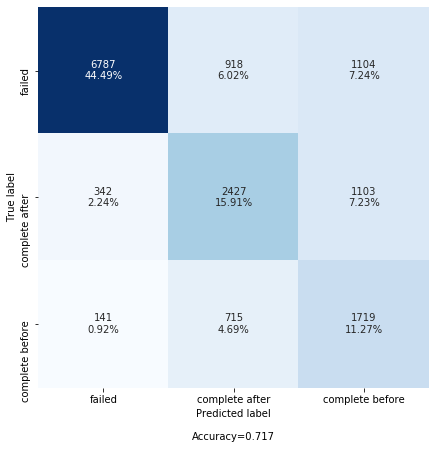

In [17]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling = {'failed': 0, 'complete after':1, 'complete before':2}

exploratory_training(labels=complete_from_view, labels_compact=labelling, **best_params)

#### Results - Improvement in accuracy with tuned hyper parameters

In [18]:
accuracy_improvement = 0.7166360776088097 - 0.7102779234399581
accuracy_improvement

0.006358154168851549

* Optimising parameters led to an improvement in accuracy of only 0.6% suggesting that the default parameters values selected by CatBoost are already close to optimal.   

We can also compare our accuracy to a model trained using only basic features without the extensive feature engineering done in the previous section:

#### Comparing with un-engineered basic model using optimal hyper parameters

0:	learn: 1.0927004	test: 1.0929383	best: 1.0929383 (0)	total: 101ms	remaining: 11m 46s
500:	learn: 0.7244862	test: 0.7577960	best: 0.7577960 (500)	total: 47.4s	remaining: 10m 15s
1000:	learn: 0.7039035	test: 0.7521667	best: 0.7521514 (998)	total: 1m 33s	remaining: 9m 20s
bestTest = 0.7520916564
bestIteration = 1054
Shrink model to first 1055 iterations.



'Learning Rate set to: 0.009999999776'

'Accuracy Score: 0.6716701625589931'

'Weights: [1.7864302777647665, 3.435127223598289, 6.706259890979426]'

                 precision    recall  f1-score   support

         failed       0.92      0.72      0.81      8809
 complete after       0.54      0.61      0.57      3872
complete before       0.38      0.60      0.47      2575

       accuracy                           0.67     15256
      macro avg       0.62      0.64      0.62     15256
   weighted avg       0.73      0.67      0.69     15256



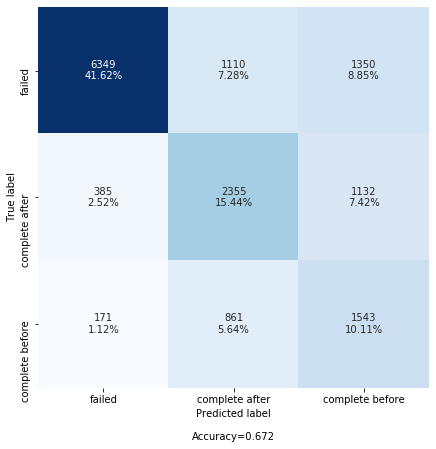

In [15]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling = {'failed': 0, 'complete after':1, 'complete before':2}

exploratory_training(labels=complete_from_view, labels_compact=labelling, feature_engineering=False, **best_params)

#### Results - Improvement in accuracy best model vs basic features

In [31]:
accuracy_improvement = 0.7166360776088097 - 0.6716701625589931
accuracy_improvement

0.04496591504981651

Here we see that feature engineering resulted in a 4.5% improvement in accuracy vs a basic model, when using the same optimised hyper parameters.

### 4.9. Results for Predicting offer completion binary

In [119]:
results_person, best_scores = grid_search_results('complete_gridsearch', 5)

,Metric,Params,Score
1,logloss_mean,"{'depth': 7, 'l2_leaf_reg': 3, 'learning_rate'...",0.348861
2,Accuracy_mean,"{'depth': 9, 'l2_leaf_reg': 1, 'learning_rate'...",0.840944
3,iteration_mean,"{'depth': 7, 'l2_leaf_reg': 3, 'learning_rate'...",208.4


,Parameters,logloss0,Accuracy0,iteration0,logloss1,Accuracy1,iteration1,logloss2,Accuracy2,iteration2,logloss3,Accuracy3,iteration3,logloss4,Accuracy4,iteration4,logloss_mean,Accuracy_mean,iteration_mean
0,"{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.07}",0.422632,0.783677,397,0.357815,0.838545,192,0.332788,0.852311,184,0.314578,0.864405,556,0.327861,0.856834,223,0.351135,0.839154,310.4
1,"{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}",0.422619,0.783776,796,0.357919,0.839921,493,0.332392,0.851524,533,0.320245,0.85821,662,0.320974,0.859882,557,0.35083,0.838663,608.2
2,"{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.01}",0.422698,0.784267,1762,0.356932,0.83825,1259,0.333271,0.851327,1762,0.324929,0.859685,812,0.322745,0.858997,1730,0.352115,0.838505,1465
3,"{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.07}",0.42219,0.784661,232,0.362201,0.835693,235,0.335489,0.849361,195,0.316048,0.86116,629,0.324031,0.857522,259,0.351992,0.837679,310
4,"{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03}",0.422314,0.784661,538,0.357693,0.839331,496,0.332504,0.852212,708,0.315782,0.861455,1046,0.326563,0.857719,652,0.350971,0.839076,688
5,"{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.01}",0.422029,0.784562,1811,0.358094,0.837365,1063,0.333525,0.850836,1461,0.316274,0.859882,2999,0.323875,0.857522,1350,0.350759,0.838033,1736.8
6,"{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.07}",0.421943,0.783776,329,0.358173,0.839823,216,0.335137,0.849361,333,0.320559,0.858702,273,0.326365,0.855457,289,0.352435,0.837424,288
7,"{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.03}",0.421956,0.784562,767,0.357716,0.83943,352,0.332655,0.850344,771,0.318186,0.860079,961,0.322488,0.858014,613,0.3506,0.838486,692.8
8,"{'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.01}",0.421887,0.784267,2144,0.358135,0.838446,1101,0.333107,0.850442,1723,0.315477,0.860669,2738,0.328253,0.856539,954,0.351372,0.838073,1732
9,"{'depth': 6, 'l2_leaf_reg': 10, 'learning_rate': 0.07}",0.42099,0.786234,374,0.361422,0.835103,179,0.335663,0.849558,369,0.317741,0.859587,380,0.33102,0.853982,272,0.353367,0.836893,314.8


#### Best Accuracy Parameters:

In [40]:
best_params = best_scores.Params[2]
best_params

{'depth': 9, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

#### Retraining using the full train set with the highest accuracy parameters against the final test data:

0:	learn: 0.6781110	test: 0.6774876	best: 0.6774876 (0)	total: 43.3ms	remaining: 5m 2s
500:	learn: 0.2947834	test: 0.3372557	best: 0.3372557 (500)	total: 20.5s	remaining: 4m 26s
bestTest = 0.3330924403
bestIteration = 855
Shrink model to first 856 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.8472732039853172'

'Weights: [1.7864302777647665, 2.2715685398612226]'

              precision    recall  f1-score   support

      failed       0.92      0.81      0.86      8809
    complete       0.77      0.90      0.83      6447

    accuracy                           0.85     15256
   macro avg       0.85      0.85      0.85     15256
weighted avg       0.86      0.85      0.85     15256



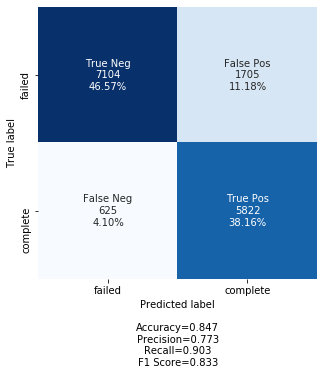

In [41]:
complete = {'completed_not_viewed': 1, 
                    'completed_before_viewed': 1, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling_complete = {'failed': 0, 'complete':1}

exploratory_training(labels=complete, labels_compact=labelling_complete, **best_params)

#### Comparing to the default CatBoost selected parameters

0:	learn: 0.6788512	test: 0.6781514	best: 0.6781514 (0)	total: 81.7ms	remaining: 9m 31s
500:	learn: 0.3300336	test: 0.3436701	best: 0.3436701 (500)	total: 14.1s	remaining: 3m 3s
1000:	learn: 0.3152207	test: 0.3335612	best: 0.3335612 (1000)	total: 37.7s	remaining: 3m 45s
1500:	learn: 0.3039539	test: 0.3292160	best: 0.3292022 (1498)	total: 1m 11s	remaining: 4m 23s
bestTest = 0.3269393971
bestIteration = 1936
Shrink model to first 1937 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.8512060828526481'

'Weights: [1.7864302777647665, 2.2715685398612226]'

              precision    recall  f1-score   support

      failed       0.92      0.81      0.86      8809
    complete       0.78      0.91      0.84      6447

    accuracy                           0.85     15256
   macro avg       0.85      0.86      0.85     15256
weighted avg       0.86      0.85      0.85     15256



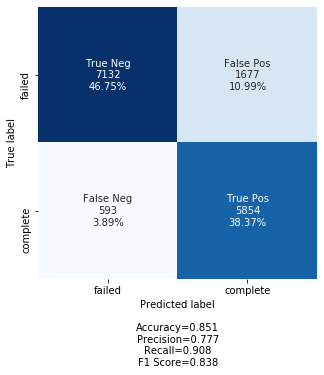

In [45]:
exploratory_training(labels=complete, labels_compact=labelling_complete)

### Results - Accuracy with tuned vs default hyper parameters

In [63]:
accuracy_improvement = 0.8472732039853172 - 0.8512060828526481
accuracy_improvement

-0.003932878867330847

In this case when extended to train with the full train set vs the final test set, we see an accuracy of 84.7%, slightly less than the default CatBoost parameters which scored 85.1% accuracy. We will therefore choose the default parameters as optimal.

#### Comparing with un-engineered basic model using optimal hyper parameters
* Comparing our accuracy to a model trained using only basic features without feature engineering:

0:	learn: 0.6790952	test: 0.6787277	best: 0.6787277 (0)	total: 35ms	remaining: 4m 5s
bestTest = 0.3850114922
bestIteration = 225
Shrink model to first 226 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.8167278447823807'

'Weights: [1.7864302777647665, 2.2715685398612226]'

              precision    recall  f1-score   support

      failed       0.90      0.76      0.83      8809
    complete       0.73      0.89      0.80      6447

    accuracy                           0.82     15256
   macro avg       0.82      0.83      0.82     15256
weighted avg       0.83      0.82      0.82     15256



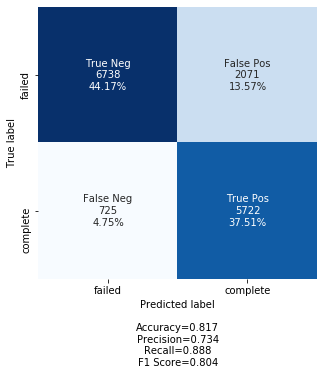

In [42]:
exploratory_training(labels=complete, labels_compact=labelling_complete, feature_engineering=False, **best_params)

In [51]:
accuracy_improvement = 0.8512060828526481 - 0.8167278447823807
accuracy_improvement

0.0344782380702674

Feature engineering in this case lead to an increase in accuracy of 3.45% vs a basic model using the default (which in this case are also optimal) CatBoost hyper parameters. 

# <<<------ OLD STUFF -------->>>

In [ ]:





# test grid, uncomment to test


gridsearch_early_stopping(cv, X_train, y_train, folds, grid, cat_features=cat_features, save='grid_search__time_series_27_10_fold')

In [48]:
def exploratory_training(labels=None, labels_compact=None):
    df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
    df = label_creater(df, label_grid=labels)
    cat_features = [0,4,5,92,93,94,95,96,97]

    df.sort_values('time_days', inplace=True)

    X = df.drop('label', axis=1)
    y = df.label

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    
    weights = [df.label.value_counts().sum() / df.label.value_counts()[i] for i in range(0, df.label.nunique())]

    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    model = CatBoostClassifier(
        iterations=7000,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        task_type='GPU',
        cat_features=cat_features,
        class_weights= weights,
        verbose=False)    

    model.fit(train_pool,
          eval_set=test_pool,
          verbose=500,
          plot=False);
    
    if not labels_compact:
        labels_compact=labels
          
    preds_class = model.predict(X_test)
    print("")
    display(F'Learning Rate set to: {model.get_all_params()["learning_rate"]}')
    display(F'Accuracy Score: {accuracy_score(y_test, preds_class)}')
    #print(F'Label_counts: {y_test.value_counts().sort_index()}')
    display(F'Weights: {weights}')
    matrix = confusion_matrix(y_test, preds_class)
    width = len(labels_compact)*2 + 1
    #cf_matrix.make_confusion_matrix(matrix, figsize=(width,width), cbar=False, categories=labels_compact.keys(), group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos'])
    
    print(classification_report(y_test, preds_class, target_names=list(labels_compact.keys())))   
    
    #cf_matrix = confusion_matrix(y_test, preds_class)
    #display(matrix)
    return model

In [51]:
complete = {'completed_not_viewed': 1, 
        'completed_before_viewed': 1, 
        'complete_anyway': 1,
        'completed_responsive': 1,
        'incomplete_responsive': 0,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'failed':0, 'completed':1}

In [52]:
model = exploratory_training(labels=complete, labels_compact=labelling)

0:	learn: 0.6788512	test: 0.6781514	best: 0.6781514 (0)	total: 81.1ms	remaining: 9m 27s
500:	learn: 0.3301964	test: 0.3434503	best: 0.3434503 (500)	total: 34.4s	remaining: 7m 26s
1000:	learn: 0.3149920	test: 0.3330756	best: 0.3330756 (1000)	total: 53.3s	remaining: 5m 19s
1500:	learn: 0.3035724	test: 0.3292066	best: 0.3292066 (1500)	total: 1m 11s	remaining: 4m 23s
bestTest = 0.3272807596
bestIteration = 1941
Shrink model to first 1942 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.8514027267960147'

'Weights: [1.7864302777647665, 2.2715685398612226]'

              precision    recall  f1-score   support

      failed       0.92      0.81      0.86      8809
   completed       0.78      0.91      0.84      6447

    accuracy                           0.85     15256
   macro avg       0.85      0.86      0.85     15256
weighted avg       0.86      0.85      0.85     15256



In [53]:
model.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'MultiClass',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 7000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Plain',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.1000000015,
 'one_hot_max_size': 2,
 'devices': '-1',
 'pinned_memory_bytes': '104857600',
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'fold_size_loss_normalization': False,
 'max_ctr_complexity': 4,
 'gpu_cat_features_storage': 'GpuRam',
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:Targe

In [46]:
def label_creater(df, label_grid=None):
    
    '''
    Creates prediction label column based on label_grid dictionary criteria
        
    Parameters
    -----------
    df:  DataFrame
    label_grid: dictionary to assign labels
            
    Returns
    -------
    DataFrame
    '''  
       
    
    df['completed_not_viewed'] = ((df.completed == 1) & (df.viewed == 0)) * label_grid['completed_not_viewed']
    
    df['completed_before_viewed'] = (((df.completed == 1) & (df.viewed == 1)) 
                                       & (df.received_spend > df.difficulty)
                                     ) * label_grid['completed_before_viewed']
    
    # Required completion spending per time left < base rate
    df['complete_anyway'] = (((df.completed == 1) & (df.viewed == 1)) 
                                & (df.viewed_spend / df.viewed_days_left <= df.amount_per_day_not_offer)
                             )* label_grid['complete_anyway']
    
    # Required completion spending per time left > base rate
    df['completed_responsive'] = (((df.completed == 1) & (df.viewed == 1) & ~(df.received_spend > df.difficulty))
                                 & (((df.viewed_spend / df.viewed_days_left > df.amount_per_day_not_offer) 
                                    | (pd.isna(df.amount_per_day_not_offer) 
                                       & ~(df.received_spend > df.difficulty))
                                    )))* label_grid['completed_responsive']
    
    # Didn't complete, spending wasn't increased above base spending
    df['incomplete_responsive'] = (((df.completed == 0) & (df.viewed == 1)) 
                                     & ((((df.viewed_spend / df.viewed_days_left) > df.amount_per_day_not_offer))
                                       | ((df.viewed_spend > 0) & pd.isna(df.amount_per_day_not_offer)
                                         )))* label_grid['incomplete_responsive']
        
    df['no_complete_no_view'] = ((df.completed == 0) & (df.viewed == 0))* label_grid['no_complete_no_view']
    
    df['unresponsive'] = ((df['completed_not_viewed']==0) & 
                          (df['completed_before_viewed']==0) & 
                          (df['complete_anyway']) & 
                          (df['completed_responsive']) & 
                          (df['incomplete_responsive']) & 
                          (df['no_complete_no_view'])
                          )* label_grid['unresponsive']  
    
    
    df['label'] = df[['completed_not_viewed', 'completed_before_viewed', 'complete_anyway', 'completed_responsive',
       'incomplete_responsive', 'unresponsive', 'no_complete_no_view']].sum(axis=1)
    
    df.drop(['received_spend',
            'viewed_spend',
            'viewed_days_left',
            'remaining_to_complete',
            'viewed_in_valid',
            'viewed',
            'spend>required',
            'offer_spend',
            'completed',
            'completed_not_viewed',
            'completed_before_viewed',
            'complete_anyway',
            'completed_responsive',
            'incomplete_responsive',
            'no_complete_no_view',
            'unresponsive',], axis=1, inplace=True)
    
    return df